In [ ]:
#default_exp process_duplicates

# Process Duplicates

> Process duplicate images by deleting them / doing other stuff to them.

In [ ]:
#hide 
from nbdev.showdoc import *

In [ ]:
#export
from fastcore.all import *
from cdiscount.find_duplicates import set_index_and_sort
import pandas as pd
from PIL import Image

Doing product-level predictions complicates if you want to keep or remove images. Since I plan to do product-level predictions, I will just do the following:
1. For images that appear in a single category in train and in test:
    - Label those products in test, and remove those products from test set
    - Check how many products of this category in train have this image
        - If all products of this category contain this image, remove all those products from train set too
2. For images that appear in multiple categories in train:
    - And doesn't appear in test:
        - Leave them in and do nothing
    - And does appear in test:
        - Leave them and do nothing -> network should learn class distribution of those images and, combined with product's other images, predict a good guess

## Load Duplicate CSVs

In [ ]:
path = Path("../data/"); path.ls()

(#16) [Path('../data/multiple_categories.csv'),Path('../data/sample_submission.csv'),Path('../data/train.bson'),Path('../data/train_hashes.csv'),Path('../data/train_example.bson'),Path('../data/cdiscount-image-classification-challenge.zip'),Path('../data/TESTING'),Path('../data/multiple_categories_and_in_train_and_test.csv'),Path('../data/test.bson'),Path('../data/test.csv')...]

In [ ]:
multiple_categories_df = pd.read_csv(path/"multiple_categories.csv", index_col=["image_hash", "image_name"])
multiple_categories_df.head()

_id  category_id  \
image_hash                       image_name                              
0000b13eda0e6b04f774c400978546da 11499177_2.jpg  11499177   1000002548   
                                 11715146_2.jpg  11715146   1000002526   
                                 19777771_2.jpg  19777771   1000002548   
                                 23142143_1.jpg  23142143   1000002526   
00011e33b07ea6bede01a235adbbbef1 14880388_0.jpg  14880388   1000012414   

                                                 in_test  
image_hash                       image_name               
0000b13eda0e6b04f774c400978546da 11499177_2.jpg    False  
                                 11715146_2.jpg    False  
                                 19777771_2.jpg    False  
                                 23142143_1.jpg    False  
00011e33b07ea6bede01a235adbbbef1 14880388_0.jpg    False

In [ ]:
in_train_and_test_df = pd.read_csv(path/"in_train_and_test.csv", index_col=["image_hash", "image_name"])
in_train_and_test_df.head()

_id  category_id  \
image_hash                       image_name                              
0000145bdf6e46ee11e292eaaf33ebde 10047043_0.jpg  10047043   1000012585   
                                 16599078_0.jpg  16599078           -1   
0000662f4f30d0db5810955b46a5a999 11812363_1.jpg  11812363   1000002638   
                                 4214251_0.jpg    4214251           -1   
000085ad497bcf27b17fed25ae8c247d 1093986_0.jpg    1093986           -1   

                                                 in_test  
image_hash                       image_name               
0000145bdf6e46ee11e292eaaf33ebde 10047043_0.jpg    False  
                                 16599078_0.jpg     True  
0000662f4f30d0db5810955b46a5a999 11812363_1.jpg    False  
                                 4214251_0.jpg      True  
000085ad497bcf27b17fed25ae8c247d 1093986_0.jpg      True

In [ ]:
both_df = pd.read_csv(path/"multiple_categories_and_in_train_and_test.csv", index_col=["image_hash", "image_name"])
both_df.head()

_id  category_id  \
image_hash                       image_name                              
0002a12d8a86efda95231ba3fc49136a 14855234_3.jpg  14855234   1000010855   
                                 18912372_0.jpg  18912372   1000010832   
                                 5555103_0.jpg    5555103   1000010855   
                                 6274963_0.jpg    6274963   1000010832   
0005e98e183c3b17e451058d4c390f26 20676570_0.jpg  20676570   1000010669   

                                                 in_test  
image_hash                       image_name               
0002a12d8a86efda95231ba3fc49136a 14855234_3.jpg    False  
                                 18912372_0.jpg    False  
                                 5555103_0.jpg     False  
                                 6274963_0.jpg     False  
0005e98e183c3b17e451058d4c390f26 20676570_0.jpg    False

In [ ]:
len(multiple_categories_df), len(in_train_and_test_df), len(both_df)

(1172215, 5352790, 965663)

In [ ]:
lbls_df = pd.read_csv(path/"category_names.csv").set_index("category_id"); lbls_df.head()

,category_level1,category_level2,category_level3
category_id,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR


## Images that appear in a single category in train and in test

In [ ]:
in_train_and_test_single_category_df = in_train_and_test_df[~in_train_and_test_df.index.get_level_values(0
                                                                ).isin(both_df.index.get_level_values(0))]
in_train_and_test_single_category_df.head()

_id  category_id  \
image_hash                       image_name                              
0000145bdf6e46ee11e292eaaf33ebde 10047043_0.jpg  10047043   1000012585   
                                 16599078_0.jpg  16599078           -1   
0000662f4f30d0db5810955b46a5a999 11812363_1.jpg  11812363   1000002638   
                                 4214251_0.jpg    4214251           -1   
000085ad497bcf27b17fed25ae8c247d 1093986_0.jpg    1093986           -1   

                                                 in_test  
image_hash                       image_name               
0000145bdf6e46ee11e292eaaf33ebde 10047043_0.jpg    False  
                                 16599078_0.jpg     True  
0000662f4f30d0db5810955b46a5a999 11812363_1.jpg    False  
                                 4214251_0.jpg      True  
000085ad497bcf27b17fed25ae8c247d 1093986_0.jpg      True

In [ ]:
len(in_train_and_test_single_category_df)

4132594

This gives us a way to label from test products and remove them from the test set.

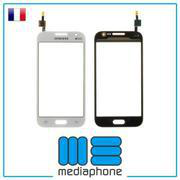

In [ ]:
Image.open(path/"images"/"10047043_0.jpg")

In [ ]:
lbls_df.loc[1000012585]

category_level1        TELEPHONIE - GPS
category_level2    ACCESSOIRE TELEPHONE
category_level3      ECRAN DE TELEPHONE
Name: 1000012585, dtype: object

### Record Labels 

In [ ]:
in_train_and_test_single_category_df.head()

_id  category_id  \
image_hash                       image_name                              
0000145bdf6e46ee11e292eaaf33ebde 10047043_0.jpg  10047043   1000012585   
                                 16599078_0.jpg  16599078           -1   
0000662f4f30d0db5810955b46a5a999 11812363_1.jpg  11812363   1000002638   
                                 4214251_0.jpg    4214251           -1   
000085ad497bcf27b17fed25ae8c247d 1093986_0.jpg    1093986           -1   

                                                 in_test  
image_hash                       image_name               
0000145bdf6e46ee11e292eaaf33ebde 10047043_0.jpg    False  
                                 16599078_0.jpg     True  
0000662f4f30d0db5810955b46a5a999 11812363_1.jpg    False  
                                 4214251_0.jpg      True  
000085ad497bcf27b17fed25ae8c247d 1093986_0.jpg      True

In [ ]:
def testIDs2category(group):
    test_ids = group[group["in_test"]]["_id"].tolist()
    category = group["category_id"].unique().tolist()
    category.remove(-1)  # Remove test category
    assert len(category) == 1  # Each image hash should only have a single category
    return test_ids, category[0]

In [ ]:
%time test2category = in_train_and_test_single_category_df.groupby("image_hash").apply(testIDs2category)

CPU times: user 2min 42s, sys: 0 ns, total: 2min 42s
Wall time: 2min 41s


In [ ]:
labeled_test_products_df = pd.DataFrame(test2category.tolist(), columns=["_id", "category_id"], ).explode("_id")
labeled_test_products_df.drop_duplicates(inplace=True)
labeled_test_products_df.head()

,_id,category_id
0,16599078,1000012585
1,4214251,1000002638
2,1093986,1000003950
3,4627059,1000007345
4,3296897,1000018246


In [ ]:
len(labeled_test_products_df)

635410

In [ ]:
len(labeled_test_products_df["_id"].unique())

633677

Hmm, it looks like some test products that share images with train products of different categories.

In [ ]:
pd.read_csv(path/"sample_submission.csv")

,_id,category_id
0,10,1000010653
1,14,1000010653
2,21,1000010653
3,24,1000010653
4,27,1000010653
...,...,...
1768177,23620214,1000010653
1768178,23620229,1000010653
1768179,23620240,1000010653
1768180,23620270,1000010653


### Checking proportion of train products in category that contain this image 

This will tell us if this product is useful to learn. If all the train product's of this category contain this image, then all products of this category in the test set will probably contain this image. If that is true, then we will have labeled all the products of this category in the test set. Hence, we can no longer need to predict this category and can remove all instances of this category in the train set.

For each `image_hash` in the previous table, we want to compute

$$\frac{\mathbf{# of products in train with image}}{\mathbf{# of products in train in total}}$$

, where both numbers are products of the same category.

In [ ]:
df = in_train_and_test_single_category_df.reset_index().groupby("category_id").apply(lambda g: len(g["_id"].unique()))

In [ ]:
df.head()

category_id
-1             749462
 1000000237         1
 1000000243         1
 1000000249       368
 1000000251       124
dtype: int64

In [ ]:
train_csv = pd.read_csv(path/"train.csv"); train_csv.head() 

,_id,category_id
0,0,1000010653
1,1,1000010653
2,2,1000004079
3,3,1000004141
4,4,1000015539


In [ ]:
def num_products_in_category(category_id: int): return (train_csv["category_id"] == category_id).sum()

In [ ]:
num_products_in_category(1000010653)

61688

In [ ]:
[num_products / num_products_in_category(category) for category, num_products in df.iteritems() if category != -1]

[0.0049261083743842365,
 0.013333333333333334,
 0.08646616541353383,
 0.09005083514887437,
 0.01764705882352941,
 0.2692307692307692,
 0.013157894736842105,
 0.04878048780487805,
 0.02631578947368421,
 0.056338028169014086,
 0.08522727272727272,
 0.19078947368421054,
 0.02403846153846154,
 0.06774193548387097,
 0.0625,
 0.09090909090909091,
 0.008849557522123894,
 0.08108108108108109,
 0.04918032786885246,
 0.01838235294117647,
 0.06349206349206349,
 0.06786050895381715,
 0.10204081632653061,
 0.0364963503649635,
 0.057692307692307696,
 0.021532091097308487,
 0.02997601918465228,
 0.021292217327459617,
 0.0625,
 0.058997050147492625,
 0.04742684157416751,
 0.01020408163265306,
 0.03125,
 0.11044776119402985,
 0.05851063829787234,
 0.06818181818181818,
 0.021505376344086023,
 0.070873786407767,
 0.011764705882352941,
 0.03389830508474576,
 0.021505376344086023,
 0.19560878243512975,
 0.2361111111111111,
 0.04691358024691358,
 0.11805555555555555,
 0.15724052206339342,
 0.384980706441080